In [ ]:
# Group members: Romina and Sahand. feb 2025.

## Some comparisons of filtering and smoothing (can be with or without the viewer)

### Hint for your task 2)
#### You must implement your filtering / smoothing in the HMMFilter / HMMSmoother classes in the file Filters. For the filter, this means also that you can use the visualisation through the Localizer, but you can call filter / smooth also directly from here, without the Localiser. Note also, that you must make use of the given models and the robot simulator in RobotSim!


In [1]:
from models import *
from Filters import HMMFilter, HMMSmoother

import numpy as np
import matplotlib.pyplot as plt
import random

In [69]:
# Simple forward filtering: Test
np.set_printoptions(threshold=np.inf)

# Set up: Models
grid_size = 8
sm = StateModel(grid_size, grid_size)
tm = TransitionModel(sm)
#om = ObservationModel_UF.ObservationModelUF(sm)
om = ObservationModel_NUF.ObservationModel(sm)

# The initial position of the robot is a random cell
true_states = []
true_states.append(random.randint(0, sm.get_num_of_states() - 1))
sense = []
sense.append(None)

number_steps = 10 # Number of steps the robot will take in this test

# We set up an f matrix to store the distributions at each step
f = np.zeros((sm.get_num_of_states(), number_steps + 1))
f[:,0] = np.ones(sm.get_num_of_states()) / (sm.get_num_of_states()) # Start with an uniform distribution for every state

# The robot simulator is started at the first position
rs = RobotSim(true_states[0], sm)

# Initializing HMM filter
filter_HMM = HMMFilter(f[:,0], tm, om, sm)

# We will store the guess at each time slice
guess = []
guess.append(sm.state_to_position(np.argmax(f[:,0])))
# guess.append((0,0)) # We do not make a guess in the starting state (So) because we have not made any observations

counter_correct_guesses = 0
sum_manhattan_d = 0

for i in range(1, number_steps + 1):
    true_states.append(rs.move_once(tm))
    sense.append(rs.sense_in_current_state(om))
    f[:,i] = filter_HMM.filter(sense[i])

    # Take a guess (Code taken from Localizer.py)
    fPositions = f[:,i].copy()        
    for state in range(0, sm.get_num_of_states(), 4) :
        fPositions[state:state+4] = sum(fPositions[state:state+4])
        
    guess.append(sm.state_to_position(np.argmax(fPositions))) # Guesses position with greatest probability
    
    ret = False  
    tsX, tsY, tsH = sm.state_to_pose(true_states[i])
    srX = -1
    srY = -1
    if sense[i] != None:
        srX, srY = sm.reading_to_position(sense[i])        
        ret = True
    else:
        ret = False        
    eX, eY = guess[i]
    
    error = abs(tsX-eX)+abs(tsY-eY) # Absolute error from True state and Guessed state (Manhattan distance)
    sum_manhattan_d = sum_manhattan_d + error
    if (eX == tsX and eY == tsY):
        counter_correct_guesses = counter_correct_guesses + 1

    # Print relevant information for each step (Comment if not necessary)
    #print(str(i) + " step:")
    #print("\t True State: " + "x:" + str(tsX) + " y:" + str(tsY) + " h:" + str(tsH))
    #if (srX or srY < 0):
    #    print("\t Reading: None")    
    #else: 
    #    print("\t Reading: "+ "x:" + str(srX) + " y:" + str(srY))
    #print("\t Guess: "+ "x:" + str(eX)+ " y:"  + str(eY))
    #print("\t Manhattan distance: " + str(error))
    #if (eX == tsX and eY == tsY):
    #    print("\t Guessed correctly")
    #else:
    #    print("\t Guessed incorrectly")
    #print("------------------------------------------")

# Summary
print("Summary. Forward Filtering")
print("\t Grid size: " + str(grid_size) + "x" + str(grid_size) + " | Number of steps taken: " + str(number_steps))
print("\t Correct estimates: Total = " + str(counter_correct_guesses) + " | Rate = " + str(counter_correct_guesses/number_steps * 100) + " %")
print("\t Average Manhattan distance: " + str(sum_manhattan_d/number_steps))

Summary. Forward Filtering
	 Grid size: 8x8 | Number of steps taken: 10
	 Correct estimates: Total = 3 | Rate = 30.0 %
	 Average Manhattan distance: 1.7


In [70]:
# Smoothing. Test #1
# We use the observations and distributions gathered from the filtering test above. Run before this block.

# Initializing HMM smoother (to call the smooth() method)
smoother_HMM = HMMSmoother(tm, om, sm)

k = 1 # fk distribution to be smoothed
# sensor_r_seq is the sequence (array) with the t-k sensor readings for smoothing
sensor_r_seq = sense[k+1: len(sense)]
fk = f[:,k]
fs = smoother_HMM.smooth(sensor_r_seq, fk)

# Summary. Smoothing test for one time slice in the past
print("Smoothing for step " + str(k) + " in " + str(number_steps) + " steps")
tsX, tsY, tsH = sm.state_to_pose(true_states[k])
print("\t True State: " + "x:" + str(tsX) + " y:" + str(tsY) + " h:" + str(tsH))
eX, eY = guess[k]
print("\t Guessed State: " + "x:" + str(eX)+ " y:"  + str(eY))
error = abs(tsX-eX)+abs(tsY-eY)
print("\t \t Previous Manhattan Distance: " + str(error))

# New Guess
fPositions = fs.copy()  
for state in range(0, sm.get_num_of_states(), 4):
    fPositions[state:state+4] = np.sum(fPositions[state:state+4])

new_guess = sm.state_to_position(np.argmax(fPositions))

neX, neY = new_guess
print("\t New Guessed State: " + "x:" + str(neX)+ " y:"  + str(neY))
new_error = abs(tsX-neX)+abs(tsY-neY)
print("\t \t New Manhattan Distance: " + str(new_error))
print("Number of observations used: " + str(len(sensor_r_seq)))

# Other printouts
#print(fk)
#print(fs)
#print(sum(fs))

Smoothing for step 1 in 10 steps
	 True State: x:6 y:6 h:2
	 Guessed State: x:4 y:4
	 	 Previous Manhattan Distance: 4
	 New Guessed State: x:3 y:5
	 	 New Manhattan Distance: 4
Number of observations used: 9


In [13]:
# Smoothing. Test #2
# This test performs the smoothing process when possible for N past observations
N = 5

# Set up. Models
grid_size = 8
sm = StateModel(grid_size, grid_size)
tm = TransitionModel(sm)
om = ObservationModel_NUF.ObservationModel(sm)
#om = ObservationModel_UF.ObservationModelUF(sm)

# Set up. Vectors and Matrices
true_states = []
true_states.append(random.randint(0, sm.get_num_of_states() - 1))

sense = []
sense.append(None)

number_steps = 500

f = np.zeros((sm.get_num_of_states(), number_steps + 1))
f[:,0] = np.ones(sm.get_num_of_states()) / (sm.get_num_of_states()) # Start with an uniform distribution for every state

guess = []
guess.append(sm.state_to_position(np.argmax(f[:,0])))

rs = RobotSim(true_states[0], sm)
filter_HMM = HMMFilter(f[:,0], tm, om, sm)
smoother_HMM = HMMSmoother(tm, om, sm)

counter_correct_guesses = 0
sum_manhattan_d = 0

# The new smoothed guess will be stored only if filtering can be done, if not, it will take the same value as the old guess

smoothed_guess = []
smoothed_guess.append(guess[0])

smoothed_counter_correct_guesses = 0
smoothed_sum_manhattan_d = 0

# This code performs forward-backward filtering
for i in range(1, number_steps + 1): # For a certain number of steps
    
    # Filtering for current time slice
    true_states.append(rs.move_once(tm))
    sense.append(rs.sense_in_current_state(om))
    f[:,i] = filter_HMM.filter(sense[i])
    
    # Take a guess for current step i (Code taken from Localizer.py)
    fPositions = f[:,i].copy() 
    for state in range(0, sm.get_num_of_states(), 4) :
        fPositions[state:state+4] = sum(fPositions[state:state+4])
        
    guess.append(sm.state_to_position(np.argmax(fPositions))) # Guesses position with greatest probability
    
    ret = False  
    tsX, tsY, tsH = sm.state_to_pose(true_states[i])
    srX = -1
    srY = -1
    if sense[i] != None:
        srX, srY = sm.reading_to_position(sense[i])        
        ret = True
    else:
        ret = False        
    eX, eY = guess[i]
    
    error = abs(tsX-eX)+abs(tsY-eY) # Absolute error from True state and Guessed state (Manhattan distance)
    sum_manhattan_d = sum_manhattan_d + error
    if (eX == tsX and eY == tsY):
        counter_correct_guesses = counter_correct_guesses + 1

    # If possible, we perform backward smoothing
    # k: time slice in which we will perform the smoothing
    smoothed_guess.append(guess[i])
    neX, neY = guess[i]
    
    k = i - N
    if k >= 0: # If we have enough observations, we perform smoothing and obtain fs for time k and a new estimate.
        # We calculate the list of observations we will use
        sensor_r_seq = sense[k+1:len(sense)]
        
        # We calculate the new distribution at k given the old distribution
        fk = f[:,k] # Old distribution
        fs = smoother_HMM.smooth(sensor_r_seq, fk)

        # We make a new estimate based on the new distribution
        fPositions = fs.copy()
        for state in range(0, sm.get_num_of_states(), 4):
            fPositions[state:state+4] = np.sum(fPositions[state:state+4])
            
        new_guess = sm.state_to_position(np.argmax(fPositions)) # Guesses position with greatest probability
        neX, neY = new_guess
        smoothed_guess[k] = new_guess
        
        # We store the new f
        f[:,k] = fs 
        
        # We compare it with the true value in the past k
        tsX, tsY, tsH = sm.state_to_pose(true_states[k])

        if (neX == tsX and neY == tsY):
                smoothed_counter_correct_guesses = smoothed_counter_correct_guesses + 1
        
        smoothed_error = abs(tsX-neX)+abs(tsY-neY)
        smoothed_sum_manhattan_d = smoothed_sum_manhattan_d + smoothed_error

# We complete the smoothed distributions calculations for those final steps that could not be smoothed
for i in range(number_steps - N + 1, number_steps + 1):
    smoothed_guess.append(guess[i])
    neX, neY = smoothed_guess[i]
    tsX, tsY, tsH = sm.state_to_pose(true_states[i])
    if (neX == tsX and neY == tsY):
        smoothed_counter_correct_guesses = smoothed_counter_correct_guesses + 1
        
    smoothed_error = abs(tsX-neX)+abs(tsY-neY)
    smoothed_sum_manhattan_d = smoothed_sum_manhattan_d + smoothed_error

print("Summary. Forward Backward Smoothing")
print("\t Grid size: " + str(grid_size) + "x" + str(grid_size) + " | Number of steps taken: " + str(number_steps))

print("\t Without Smoothing:")
print("\t \t Correct estimates: Total = " + str(counter_correct_guesses) + " | Rate = " + str(counter_correct_guesses/number_steps * 100) + " %")
print("\t \t Average Manhattan distance: " + str(sum_manhattan_d/number_steps))

print("\t With Smoothing:")
print("\t \t Correct estimates: Total = " + str(smoothed_counter_correct_guesses) + " | Rate = " + str(smoothed_counter_correct_guesses/number_steps * 100) + " %")
print("\t \t Average Manhattan distance: " + str(smoothed_sum_manhattan_d/number_steps))


Summary. Forward Backward Smoothing
	 Grid size: 8x8 | Number of steps taken: 500
	 Without Smoothing:
	 	 Correct estimates: Total = 174 | Rate = 34.8 %
	 	 Average Manhattan distance: 1.634
	 With Smoothing:
	 	 Correct estimates: Total = 275 | Rate = 55.00000000000001 %
	 	 Average Manhattan distance: 1.026


In [51]:
# 4. Evaluation. Ploting avegare Manhattan distances over time. All tests are done with 500 steps

Summary. Forward Filtering vs. Sensor
	 Forward Filtering
	 	 Grid size: 8x8 | Number of steps taken: 500
	 	 Average Manhattan distance: 1.722
	 Sensor
	 	 Grid size: 8x8 | Number of steps taken: 500
	 	 Average Manhattan distance: 1.7822349570200573
	 	 Sensor fail rate: 30.2 %


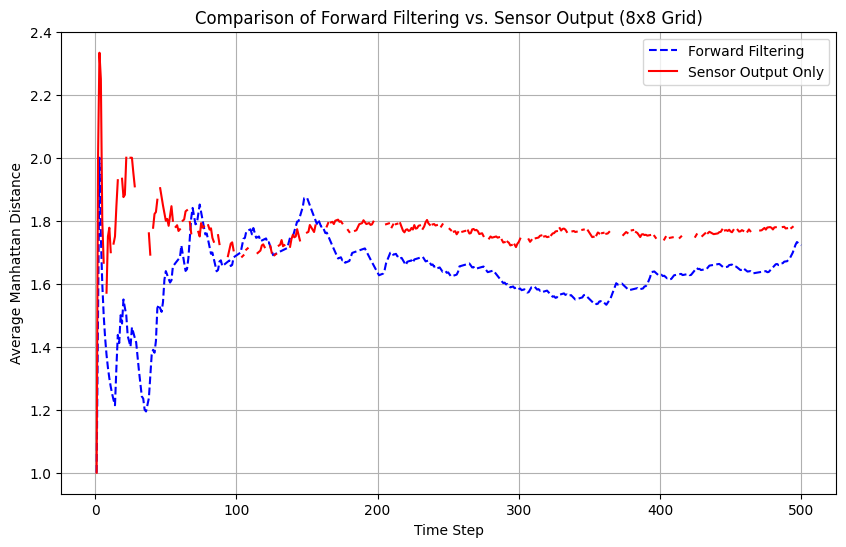

In [13]:
# Forward Filtering with NUF against Sensor output (on 8x8)
number_steps = 500

# Set up: Models
grid_size = 8
sm = StateModel(grid_size, grid_size)
tm = TransitionModel(sm)
om = ObservationModel_NUF.ObservationModel(sm)

true_states = []
true_states.append(random.randint(0, sm.get_num_of_states() - 1))
f_sense = []
f_sense.append(None)
s_sense = []
s_sense.append(None)

f = np.zeros((sm.get_num_of_states(), number_steps + 1))
f[:,0] = np.ones(sm.get_num_of_states()) / (sm.get_num_of_states())

rs = RobotSim(true_states[0], sm)
filter_HMM = HMMFilter(f[:,0], tm, om, sm)

guess = []
guess.append(sm.state_to_position(np.argmax(f[:,0])))

# We accumulate the Average Manhattan Distance
# For Forward Filtering
forward_avg_distance = np.full(number_steps, np.nan)
# For Sensor
sensor_avg_distance = np.full(number_steps, np.nan)
# Also, a time slice array is defined
time_steps = np.arange(1, number_steps + 1)

f_sum_manhattan_d = 0
s_sum_manhattan_d = 0

sensor_fail_counter = 0
sensor_success_counter = 0

# Forward Filtering and Sensor output
for i in range(1, number_steps + 1):
    true_states.append(rs.move_once(tm))
    f_sense.append(rs.sense_in_current_state(om))
    f[:,i] = filter_HMM.filter(f_sense[i])

    s_sense.append(rs.sense_in_current_state(om))
    
    # Take a guess (Code taken from Localizer.py)
    fPositions = f[:,i].copy()        
    for state in range(0, sm.get_num_of_states(), 4) :
        fPositions[state:state+4] = sum(fPositions[state:state+4])
        
    guess.append(sm.state_to_position(np.argmax(fPositions))) # Guesses position with greatest probability
    
    ret = False  
    tsX, tsY, tsH = sm.state_to_pose(true_states[i])
    srX = -1
    srY = -1
    if f_sense[i] != None:
        srX, srY = sm.reading_to_position(f_sense[i])
        ret = True
    else:
        ret = False        
    eX, eY = guess[i]

    # Store values
    f_error = abs(tsX-eX)+abs(tsY-eY)
    f_sum_manhattan_d = f_sum_manhattan_d + f_error
    forward_avg_distance[i-1] = f_sum_manhattan_d/i

    if s_sense[i] != None:
        srX, srY = sm.reading_to_position(s_sense[i])
        sensor_success_counter = sensor_success_counter + 1
        s_error = abs(tsX-srX)+abs(tsY-srY)
        s_sum_manhattan_d = s_sum_manhattan_d + s_error
        sensor_avg_distance[i-1] = s_sum_manhattan_d/sensor_success_counter
        ret = True
    else:
        sensor_fail_counter = sensor_fail_counter + 1
        ret = False        

# Summary
print("Summary. Forward Filtering vs. Sensor")
print("\t Forward Filtering")
print("\t \t Grid size: " + str(grid_size) + "x" + str(grid_size) + " | Number of steps taken: " + str(number_steps))
print("\t \t Average Manhattan distance: " + str(forward_avg_distance[number_steps-1]))
print("\t Sensor")
print("\t \t Grid size: " + str(grid_size) + "x" + str(grid_size) + " | Number of steps taken: " + str(number_steps))
print("\t \t Average Manhattan distance: " + str(s_sum_manhattan_d/sensor_success_counter))
print("\t \t Sensor fail rate: " + str(sensor_fail_counter/number_steps * 100) + " %")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_steps, forward_avg_distance, label="Forward Filtering", linestyle="--", color="blue")
plt.plot(time_steps, sensor_avg_distance, label="Sensor Output Only", linestyle="-", color="red")

plt.xlabel("Time Step")
plt.ylabel("Average Manhattan Distance")
plt.title("Comparison of Forward Filtering vs. Sensor Output (8x8 Grid)")
plt.legend()
plt.grid()
plt.show()

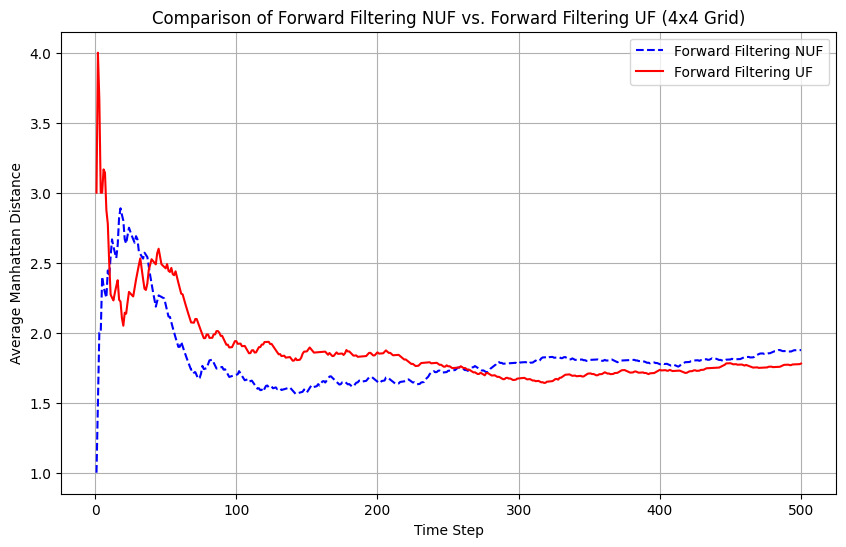

Summary. Forward Filtering NUF vs. Forward Filtering UF
	 Forward Filtering NUF
	 	 Grid size: 4x4 | Number of steps taken: 500
	 	 Average Manhattan distance: 1.876
	 Forward Filtering UF
	 	 Grid size: 4x4 | Number of steps taken: 500
	 	 Average Manhattan distance: 1.78
[57, 61, 59, 42, 26, 10, 24, 40, 39, 35, 18, 2, 5, 20, 36, 52, 57, 61, 59, 42, 26, 10, 7, 3, 5, 9, 24, 23, 36, 35, 48, 53, 57, 61, 46, 30, 27, 10, 13, 11, 7, 3, 5, 9, 13, 28, 14, 11, 7, 3, 16, 32, 48, 34, 18, 2, 16, 32, 48, 34, 18, 2, 16, 32, 48, 34, 18, 2, 16, 21, 25, 29, 44, 60, 59, 55, 51, 53, 57, 61, 46, 30, 27, 23, 19, 21, 36, 52, 57, 55, 57, 55, 51, 34, 18, 32, 37, 41, 45, 60, 59, 55, 51, 53, 57, 61, 59, 61, 59, 61, 46, 30, 44, 30, 44, 60, 59, 42, 26, 23, 19, 32, 48, 34, 18, 2, 16, 2, 16, 32, 37, 35, 37, 41, 45, 60, 59, 42, 26, 10, 13, 28, 44, 60, 59, 42, 56, 61, 59, 55, 51, 34, 18, 2, 16, 2, 16, 21, 36, 52, 57, 42, 39, 35, 48, 34, 18, 2, 16, 2, 16, 32, 48, 34, 37, 41, 56, 55, 51, 53, 51, 53, 57, 61, 59, 61, 46

In [4]:
# Forward Filtering with NUF against Forward Filtering with UF (on 4x4)
number_steps = 500

# Set up: Models
grid_size = 4
sm = StateModel(grid_size, grid_size)
tm = TransitionModel(sm)
om_NUF = ObservationModel_NUF.ObservationModel(sm)
om_UF = ObservationModel_UF.ObservationModelUF(sm)

true_states = []
true_states.append(random.randint(0, sm.get_num_of_states() - 1))
nuf_sense = []
nuf_sense.append(None)
uf_sense = []
uf_sense.append(None)

f_nuf = np.zeros((sm.get_num_of_states(), number_steps + 1))
f_nuf[:,0] = np.ones(sm.get_num_of_states()) / (sm.get_num_of_states())

f_uf = np.zeros((sm.get_num_of_states(), number_steps + 1))
f_uf[:,0] = np.ones(sm.get_num_of_states()) / (sm.get_num_of_states())

rs = RobotSim(true_states[0], sm)
nuf_filter_HMM = HMMFilter(f_nuf[:,0], tm, om_NUF, sm)
uf_filter_HMM = HMMFilter(f_uf[:,0], tm, om_UF, sm)

nuf_guess = []
nuf_guess.append(sm.state_to_position(np.argmax(f_nuf[:,0])))
uf_guess = []
uf_guess.append(sm.state_to_position(np.argmax(f_uf[:,0])))

# We accumulate the Average Manhattan Distance
nuf_avg_distance = np.full(number_steps, np.nan)
uf_avg_distance = np.full(number_steps, np.nan)
time_steps = np.arange(1, number_steps + 1)

nuf_sum_manhattan_d = 0
uf_sum_manhattan_d = 0

# Forward Filtering Loop
for i in range(1, number_steps + 1):
    true_states.append(rs.move_once(tm))
    nuf_sense.append(rs.sense_in_current_state(om_NUF))
    f_nuf[:,i] = nuf_filter_HMM.filter(nuf_sense[i])

    uf_sense.append(rs.sense_in_current_state(om_UF))
    f_uf[:,i] = uf_filter_HMM.filter(uf_sense[i])
    
    # Take a guess (Code taken from Localizer.py)
    fPositions = f_nuf[:,i].copy()        
    for state in range(0, sm.get_num_of_states(), 4) :
        fPositions[state:state+4] = sum(fPositions[state:state+4])        
    nuf_guess.append(sm.state_to_position(np.argmax(fPositions)))

    fPositions = f_uf[:,i].copy()        
    for state in range(0, sm.get_num_of_states(), 4) :
        fPositions[state:state+4] = sum(fPositions[state:state+4])        
    uf_guess.append(sm.state_to_position(np.argmax(fPositions)))
     
    tsX, tsY, tsH = sm.state_to_pose(true_states[i])     
    
    nuf_eX, nuf_eY = nuf_guess[i]
    uf_eX, uf_eY = uf_guess[i]
    
    # Store values
    nuf_error = abs(tsX-nuf_eX)+abs(tsY-nuf_eY)
    nuf_sum_manhattan_d = nuf_sum_manhattan_d + nuf_error
    nuf_avg_distance[i-1] = nuf_sum_manhattan_d/i

    uf_error = abs(tsX-uf_eX)+abs(tsY-uf_eY)
    uf_sum_manhattan_d = uf_sum_manhattan_d + uf_error
    uf_avg_distance[i-1] = uf_sum_manhattan_d/i
   
# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_steps, nuf_avg_distance, label="Forward Filtering NUF", linestyle="--", color="blue")
plt.plot(time_steps, uf_avg_distance, label="Forward Filtering UF", linestyle="-", color="red")

plt.xlabel("Time Step")
plt.ylabel("Average Manhattan Distance")
plt.title("Comparison of Forward Filtering NUF vs. Forward Filtering UF (4x4 Grid)")
plt.legend()
plt.grid()
plt.show()

# Summary
print("Summary. Forward Filtering NUF vs. Forward Filtering UF")
print("\t Forward Filtering NUF")
print("\t \t Grid size: " + str(grid_size) + "x" + str(grid_size) + " | Number of steps taken: " + str(number_steps))
print("\t \t Average Manhattan distance: " + str(nuf_avg_distance[number_steps-1]))
print("\t Forward Filtering UF")
print("\t \t Grid size: " + str(grid_size) + "x" + str(grid_size) + " | Number of steps taken: " + str(number_steps))
print("\t \t Average Manhattan distance: " + str(uf_avg_distance[number_steps-1]))

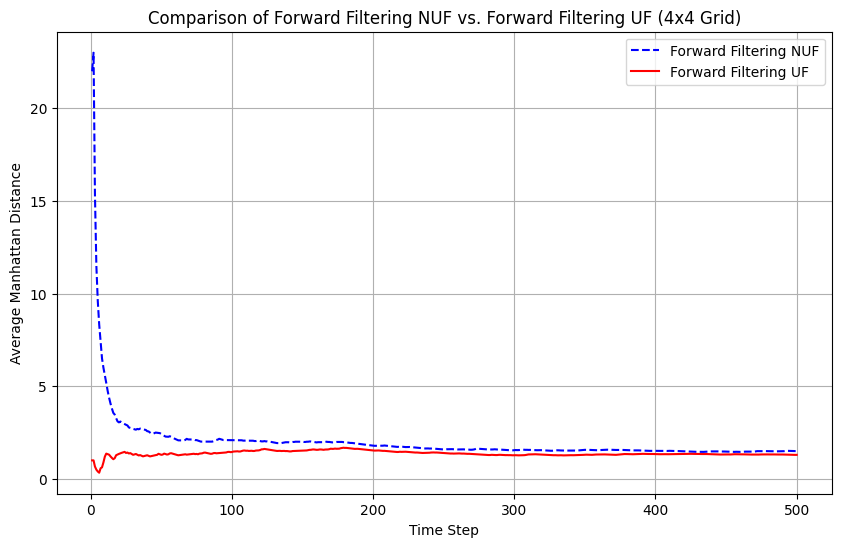

Summary. Forward Filtering NUF vs. Forward Filtering UF
	 Forward Filtering NUF
	 	 Grid size: 4x4 | Number of steps taken: 500
	 	 Average Manhattan distance: 1.502
	 Forward Filtering UF
	 	 Grid size: 4x4 | Number of steps taken: 500
	 	 Average Manhattan distance: 1.298


In [6]:
# Forward Filtering with NUF against Forward Filtering with UF (on 16x20)
number_steps = 500

# Set up: Models
grid_size_m = 16
grid_size_n = 20
sm = StateModel(grid_size_m, grid_size_n)
tm = TransitionModel(sm)
om_NUF = ObservationModel_NUF.ObservationModel(sm)
om_UF = ObservationModel_UF.ObservationModelUF(sm)

true_states = []
true_states.append(random.randint(0, sm.get_num_of_states() - 1))
nuf_sense = []
nuf_sense.append(None)
uf_sense = []
uf_sense.append(None)

f_nuf = np.zeros((sm.get_num_of_states(), number_steps + 1))
f_nuf[:,0] = np.ones(sm.get_num_of_states()) / (sm.get_num_of_states())

f_uf = np.zeros((sm.get_num_of_states(), number_steps + 1))
f_uf[:,0] = np.ones(sm.get_num_of_states()) / (sm.get_num_of_states())

rs = RobotSim(true_states[0], sm)
nuf_filter_HMM = HMMFilter(f_nuf[:,0], tm, om_NUF, sm)
uf_filter_HMM = HMMFilter(f_uf[:,0], tm, om_UF, sm)

nuf_guess = []
nuf_guess.append(sm.state_to_position(np.argmax(f_nuf[:,0])))
uf_guess = []
uf_guess.append(sm.state_to_position(np.argmax(f_uf[:,0])))

# We accumulate the Average Manhattan Distance
nuf_avg_distance = np.full(number_steps, np.nan)
uf_avg_distance = np.full(number_steps, np.nan)
time_steps = np.arange(1, number_steps + 1)

nuf_sum_manhattan_d = 0
uf_sum_manhattan_d = 0

# Forward Filtering Loop
for i in range(1, number_steps + 1):
    true_states.append(rs.move_once(tm))
    nuf_sense.append(rs.sense_in_current_state(om_NUF))
    f_nuf[:,i] = nuf_filter_HMM.filter(nuf_sense[i])

    uf_sense.append(rs.sense_in_current_state(om_UF))
    f_uf[:,i] = uf_filter_HMM.filter(uf_sense[i])
    
    # Take a guess (Code taken from Localizer.py)
    fPositions = f_nuf[:,i].copy()        
    for state in range(0, sm.get_num_of_states(), 4) :
        fPositions[state:state+4] = sum(fPositions[state:state+4])        
    nuf_guess.append(sm.state_to_position(np.argmax(fPositions)))

    fPositions = f_uf[:,i].copy()        
    for state in range(0, sm.get_num_of_states(), 4) :
        fPositions[state:state+4] = sum(fPositions[state:state+4])        
    uf_guess.append(sm.state_to_position(np.argmax(fPositions)))
     
    tsX, tsY, tsH = sm.state_to_pose(true_states[i])     
    
    nuf_eX, nuf_eY = nuf_guess[i]
    uf_eX, uf_eY = uf_guess[i]
    
    # Store values
    nuf_error = abs(tsX-nuf_eX)+abs(tsY-nuf_eY)
    nuf_sum_manhattan_d = nuf_sum_manhattan_d + nuf_error
    nuf_avg_distance[i-1] = nuf_sum_manhattan_d/i

    uf_error = abs(tsX-uf_eX)+abs(tsY-uf_eY)
    uf_sum_manhattan_d = uf_sum_manhattan_d + uf_error
    uf_avg_distance[i-1] = uf_sum_manhattan_d/i
   
# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_steps, nuf_avg_distance, label="Forward Filtering NUF", linestyle="--", color="blue")
plt.plot(time_steps, uf_avg_distance, label="Forward Filtering UF", linestyle="-", color="red")

plt.xlabel("Time Step")
plt.ylabel("Average Manhattan Distance")
plt.title("Comparison of Forward Filtering NUF vs. Forward Filtering UF (4x4 Grid)")
plt.legend()
plt.grid()
plt.show()

# Summary
print("Summary. Forward Filtering NUF vs. Forward Filtering UF")
print("\t Forward Filtering NUF")
print("\t \t Grid size: " + str(grid_size) + "x" + str(grid_size) + " | Number of steps taken: " + str(number_steps))
print("\t \t Average Manhattan distance: " + str(nuf_avg_distance[number_steps-1]))
print("\t Forward Filtering UF")
print("\t \t Grid size: " + str(grid_size) + "x" + str(grid_size) + " | Number of steps taken: " + str(number_steps))
print("\t \t Average Manhattan distance: " + str(uf_avg_distance[number_steps-1]))

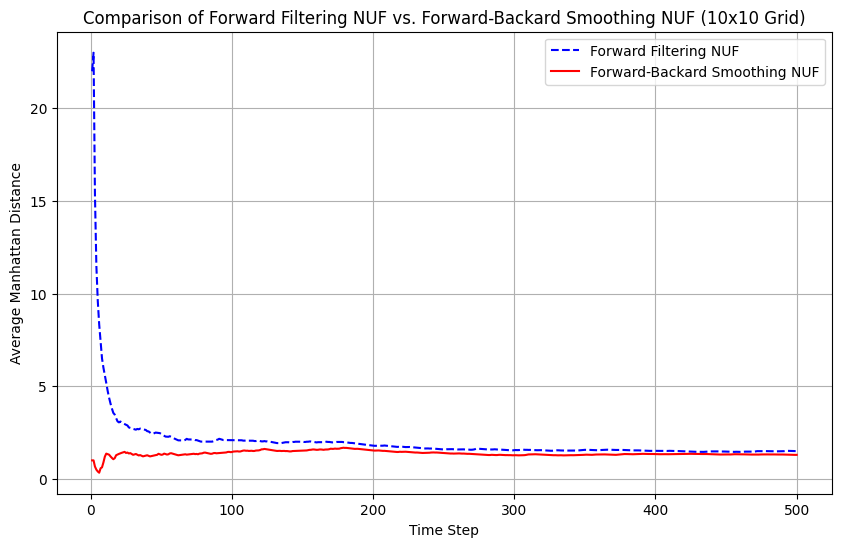

Summary. Forward Filtering vs. Forward Backward Smoothing
	 Grid size: 10x10 | Number of steps taken: 500
	 Without Smoothing:
	 	 Average Manhattan distance: 1.424
	 With Smoothing:
	 	 Average Manhattan distance: 0.818


In [14]:
# Forward Filtering with NUF against Forward-Backward Smoothing with k = t-5 (on 10x10)
# This test performs the smoothing process when possible for N past observations
N = 5
number_steps = 500
# Set up. Models
grid_size = 10
sm = StateModel(grid_size, grid_size)
tm = TransitionModel(sm)
om = ObservationModel_NUF.ObservationModel(sm)

true_states = []
true_states.append(random.randint(0, sm.get_num_of_states() - 1))
sense = []
sense.append(None)
f = np.zeros((sm.get_num_of_states(), number_steps + 1))
f[:,0] = np.ones(sm.get_num_of_states()) / (sm.get_num_of_states()) # Start with an uniform distribution for every state
guess = []
guess.append(sm.state_to_position(np.argmax(f[:,0])))
rs = RobotSim(true_states[0], sm)
filter_HMM = HMMFilter(f[:,0], tm, om, sm)
smoother_HMM = HMMSmoother(tm, om, sm)

smoothed_guess = []
smoothed_guess.append(guess[0])

f_sum_manhattan_d = 0
fb_sum_manhattan_d = 0

f_avg_distance = np.full(number_steps, np.nan)
fb_avg_distance = np.full(number_steps, np.nan)
time_steps = np.arange(1, number_steps + 1)

# This code performs forward-backward filtering
for i in range(1, number_steps + 1):
    true_states.append(rs.move_once(tm))
    sense.append(rs.sense_in_current_state(om))
    f[:,i] = filter_HMM.filter(sense[i])
    
    # Take a guess for current step i (Code taken from Localizer.py)
    fPositions = f[:,i].copy() 
    for state in range(0, sm.get_num_of_states(), 4) :
        fPositions[state:state+4] = sum(fPositions[state:state+4])        
    guess.append(sm.state_to_position(np.argmax(fPositions)))
    eX, eY = guess[i]
    
    tsX, tsY, tsH = sm.state_to_pose(true_states[i])    

    error = abs(tsX-eX)+abs(tsY-eY)
    f_sum_manhattan_d = f_sum_manhattan_d + error
    f_avg_distance[i-1] = f_sum_manhattan_d/i

    k = i - N
    if k >= 0:
        sensor_r_seq = sense[k+1:len(sense)]
        fk = f[:,k]
        fs = smoother_HMM.smooth(sensor_r_seq, fk)

        fPositions = fs.copy()
        for state in range(0, sm.get_num_of_states(), 4):
            fPositions[state:state+4] = np.sum(fPositions[state:state+4])            
        new_guess = sm.state_to_position(np.argmax(fPositions))
        neX, neY = new_guess
        smoothed_guess.append(new_guess)  

        f[:,k] = fs         
        tsX, tsY, tsH = sm.state_to_pose(true_states[k])
        
        smoothed_error = abs(tsX-neX)+abs(tsY-neY)
        fb_sum_manhattan_d = fb_sum_manhattan_d + smoothed_error
        fb_avg_distance[k] = fb_sum_manhattan_d/(k + 1)

for i in range(number_steps - N + 1, number_steps + 1):
    smoothed_guess.append(guess[i])
    neX, neY = smoothed_guess[i]
    tsX, tsY, tsH = sm.state_to_pose(true_states[i])

    smoothed_error = abs(tsX-neX)+abs(tsY-neY)
    fb_sum_manhattan_d = fb_sum_manhattan_d + smoothed_error
    fb_avg_distance[i-1] = fb_sum_manhattan_d/(i)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_steps, nuf_avg_distance, label="Forward Filtering NUF", linestyle="--", color="blue")
plt.plot(time_steps, uf_avg_distance, label="Forward-Backard Smoothing NUF", linestyle="-", color="red")

plt.xlabel("Time Step")
plt.ylabel("Average Manhattan Distance")
plt.title("Comparison of Forward Filtering NUF vs. Forward-Backard Smoothing NUF (10x10 Grid)")
plt.legend()
plt.grid()
plt.show()

# Summary
print("Summary. Forward Filtering vs. Forward Backward Smoothing")
print("\t Grid size: " + str(grid_size) + "x" + str(grid_size) + " | Number of steps taken: " + str(number_steps))

print("\t Without Smoothing:")
print("\t \t Average Manhattan distance: " + str(f_avg_distance[number_steps-1]))

print("\t With Smoothing:")
print("\t \t Average Manhattan distance: " + str(fb_avg_distance[number_steps-1]))
